In [ ]:
!pip install einops

In [ ]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

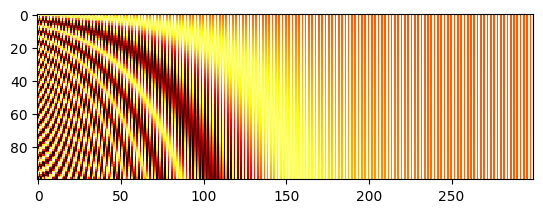

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(MyViT, self).__init__()

        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

        #Parameters
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

In [ ]:

#     # Loading data
#     transform = ToTensor()

#     train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
#     test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

#     train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
#     test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

#     # Defining model and training options
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
#     model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
#     N_EPOCHS = 5
#     LR = 0.005

#     # Training loop
#     optimizer = Adam(model.parameters(), lr=LR)
#     criterion = CrossEntropyLoss()
#     for epoch in trange(N_EPOCHS, desc="Training"):
#         train_loss = 0.0
#         for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
#             x, y = batch
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat, y)

#             train_loss += loss.detach().cpu().item() / len(train_loader)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

#     # Test loop
#     with torch.no_grad():
#         correct, total = 0, 0
#         test_loss = 0.0
#         for batch in tqdm(test_loader, desc="Testing"):
#             x, y = batch
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat, y)
#             test_loss += loss.detach().cpu().item() / len(test_loader)

#             correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
#             total += len(x)
#         print(f"Test loss: {test_loss:.2f}")
#         print(f"Test accuracy: {correct / total * 100:.2f}%")


# # Current model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
# model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

# x = torch.randn(7, 1, 28, 28) # Dummy images
# print(model(x).shape) # torch.Size([7, 49, 16])

In [ ]:
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 10
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (Tesla T4)


Training:  10%|█         | 1/10 [05:21<48:16, 321.84s/it]

Epoch 1/10 loss: 2.11



Training:  20%|██        | 2/10 [10:38<42:29, 318.73s/it]

Epoch 2/10 loss: 1.86



Training:  30%|███       | 3/10 [15:55<37:05, 317.89s/it]

Epoch 3/10 loss: 1.77



Training:  40%|████      | 4/10 [21:12<31:44, 317.46s/it]

Epoch 4/10 loss: 1.74



Training:  50%|█████     | 5/10 [26:27<26:23, 316.68s/it]

Epoch 5/10 loss: 1.72



Training:  60%|██████    | 6/10 [31:43<21:05, 316.42s/it]

Epoch 6/10 loss: 1.71



Training:  70%|███████   | 7/10 [37:00<15:50, 316.68s/it]

Epoch 7/10 loss: 1.71



Training:  80%|████████  | 8/10 [42:18<10:34, 317.10s/it]

Epoch 8/10 loss: 1.70



Training:  90%|█████████ | 9/10 [47:36<05:17, 317.29s/it]

Epoch 9/10 loss: 1.70



Training: 100%|██████████| 10/10 [52:54<00:00, 317.49s/it]


Epoch 10/10 loss: 1.70


Testing: 100%|██████████| 79/79 [00:31<00:00,  2.49it/s]

Test loss: 1.69
Test accuracy: 76.84%


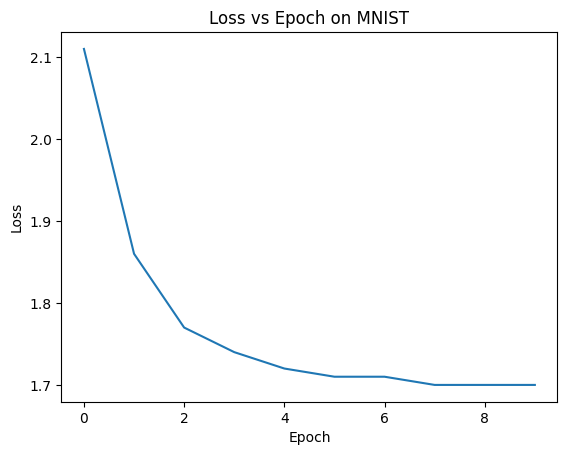

In [ ]:
loss = [2.11, 1.86, 1.77, 1.74, 1.72, 1.71, 1.71, 1.7, 1.7, 1.7]

plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch on MNIST")
plt.show()


